In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import ndimage
from datetime import datetime

In [16]:
def array_to_xarray(array,xarray):

    new_xarray = xr.DataArray(
        array,
        dims=xarray.dims,  # Use the same dimensions as the input
        coords=xarray.coords,  # Use the same coordinates as the input
        attrs=xarray.attrs,  # Preserve attributes (optional)
    )

    return new_xarray

def label_and_preserve_xarray(data_array, structure=None):

    labeled_array, num_features = ndimage.label(data_array.values, structure=structure)

    labeled_xarray = array_to_xarray(labeled_array,data_array)

    return labeled_xarray

def filter_by_area(data_array,area_var='area',groupby_type="labeled_clusters",AREA_THRESHOLD=500):
    data_array_slice = data_array[[area_var,groupby_type]]
    label_areas= data_array_slice.groupby(groupby_type).sum() 
    labels_to_keep = label_areas.where(label_areas>AREA_THRESHOLD,drop=True)
    labels_to_keep = labels_to_keep[groupby_type].values
    labels_to_keep = labels_to_keep[labels_to_keep>0]
    if len(labels_to_keep) == 0:
        labels_to_keep = 10000
    return labels_to_keep

def blob_area_filter(data_array, area_min, latitude_dim_name='latitude'):
    labeled_blobs_xarray=xr.Dataset({'labels':data_array})
    labeled_blobs_xarray['area'] = np.cos(labeled_blobs_xarray[latitude_dim_name]*np.pi/180)
    blob_areas = labeled_blobs_xarray.groupby('labels').sum()

    xr_large_blobs = xr.where(blob_areas["area"]> area_min,blob_areas["labels"],0)
    large_blobs_label = xr_large_blobs.values[xr_large_blobs.values>0]

    labeled_large_blobs = xr.where(labeled_blobs_xarray['labels'].isin(large_blobs_label),labeled_blobs_xarray['labels'],0)
    return large_blobs_label,labeled_large_blobs

def morphology(data_array,dilation_structure = np.ones((9,9))):
    
    blobs = ndimage.binary_erosion(data_array,structure=np.ones((2,2))).astype(int)
    blobs = ndimage.binary_dilation(blobs,structure=dilation_structure).astype(int)
    #blobs = ndimage.binary_closing(blobs,structure=dilation_structure).astype(int)
    blobs = ndimage.binary_fill_holes(blobs).astype(int)
    blobs_xr = array_to_xarray(array=blobs,xarray=data_array)
    return blobs_xr



In [17]:
#PARAMETERS
STDEV_THRESHOLD = -1.5
SMALL_BLOBS_FILTER = 50
AREA_THRESHOLD=1000
VARIABLE = 'anomaly_scaled'

In [18]:
ds = xr.open_dataset("temp/era5_t2min_scaled_anomalies.nc")

## Step 1: mask by stdev threshold

In [19]:
ds["mask"] = ds[VARIABLE] <= STDEV_THRESHOLD

In [20]:
ds["labeled_clusters"] = label_and_preserve_xarray(data_array=ds["mask"])
ds['area'] = np.cos(ds["latitude"]*np.pi/180)

In [21]:
#ds.groupby('time').groups
ds["labeled_clusters"] =ds['mask'].groupby('time').map(label_and_preserve_xarray)

In [22]:
ds

<xarray.Dataset> Size: 65MB
Dimensions:           (latitude: 281, longitude: 441, time: 31, season: 1)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
  * season            (season) <U3 12B 'DJF'
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude, season) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude, season) float32 15MB -0.157...
    mask              (time, latitude, longitude, season) bool 4MB False ... ...
    labeled_clusters  (time, latitude, longitude, season) int32 15MB 0 0 ... 0 0
    area              (latitude) float32 1kB -4.371e-08 0.004363 ... 0.9397

## Calculate label areas

In [ ]:
filtered_ds_list = []
for t in ds.time:
    labels_to_keep = filter_by_area(data_array=ds.sel(time=t),AREA_THRESHOLD=AREA_THRESHOLD)
    temp_ds = ds["labeled_clusters"].sel(time=t).isin(labels_to_keep).astype(int)
    filtered_ds_list.append(temp_ds)

In [ ]:
mask_for_labels = xr.concat(filtered_ds_list,dim='time')
ds['labeled_masked'] = ds["labeled_clusters"].where(mask_for_labels==1)

In [26]:
ds

<xarray.Dataset> Size: 96MB
Dimensions:           (latitude: 281, longitude: 441, time: 31, season: 1)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
  * season            (season) <U3 12B 'DJF'
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude, season) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude, season) float32 15MB -0.157...
    mask              (time, latitude, longitude, season) bool 4MB False ... ...
    labeled_clusters  (time, latitude, longitude, season) int32 15MB 0 0 ... 0 0
    area              (latitude) float32 1kB -4.371e-08 0.004363 ... 0.9397
    labeled_masked    (time, latitude, longitude, season) float64 31MB nan .....

#### Unfiltered

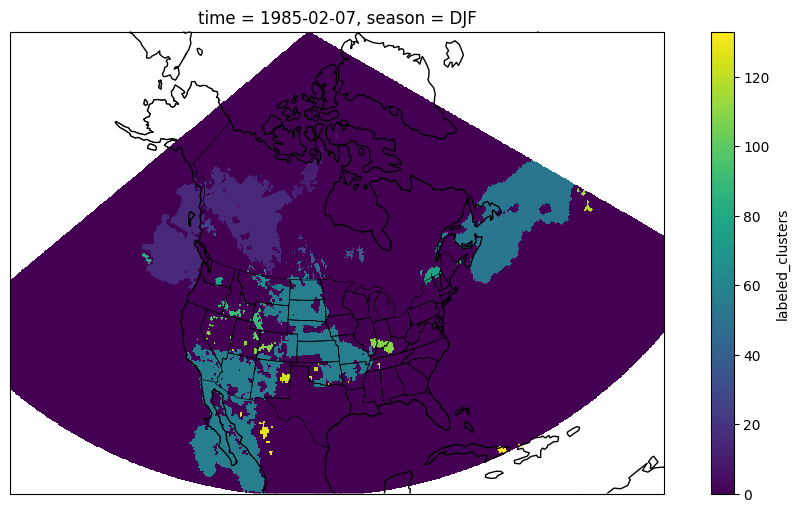

In [30]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_clusters'].plot(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

#### Filtered

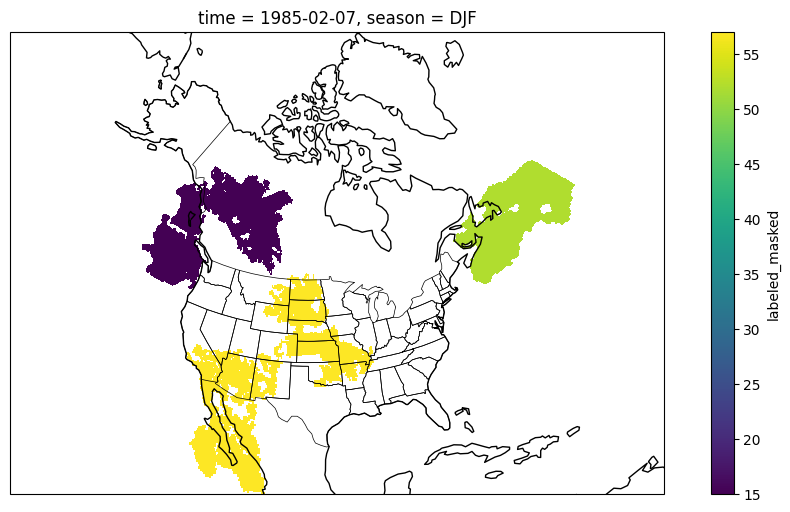

In [31]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_masked'].plot(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

In [ ]:
#temp=ds[['labeled_clusters','area']].groupby(('time','labeled_clusters')).sum()
#temp['area'].to_pandas()

labeled_clusters,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
time,,,,,,,,,,,,,,,,,,,,,
1970-02-07,63973.007812,391.476990,243.932480,8.311684,2.059111,1.499365,1.520163,0.333807,3.778602,0.337917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-07,57921.031250,1.999156,0.338699,43.528393,536.527954,0.203642,0.649319,84.851082,76.595688,5.216761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-02-07,63023.734375,1.041889,154.337845,0.609729,1419.566650,1.751037,0.354291,2.549256,4.446668,2.634372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-07,64839.242188,597.904114,0.871295,3.371255,0.139173,20.857866,1.004448,0.143493,0.143493,1.898754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-02-07,65256.296875,8.866390,0.241922,0.897953,0.601412,0.609729,0.329691,8.648736,0.342020,0.692234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-07,63722.292969,190.161682,4.719850,2.136786,138.896942,2.782089,0.477159,0.488621,4.920404,5.969685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-07,63079.824219,3.826924,0.190809,2.932683,0.559658,0.675834,12.529940,0.801496,1.196649,3.635196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-02-07,63731.128906,78.317230,82.679169,4.221828,3.022232,0.209057,8.135955,3.808843,0.860956,1.215537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-02-07,61018.683594,25.718935,0.134851,5.210974,1.087314,1548.317139,24.190453,4063.141602,4.709178,3.170749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
